<a href="https://colab.research.google.com/github/anandopt/ML_NN_COLAB/blob/master/ToolTestCoding_AnandKumar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Oceaneering Analytics Team Python Coding Test
This is a coding test for applicants to positions on the Oceaneering Analytics team. Colab behaves exactly like a Jupyter notebook, except that the runtime sits on Google.
* Only this colab workbook will be reviewed after completion of the test. Any comments or other things you as an applicant want Oceaneering to know must be written in this workbook. 
* You can include any library you want.
* Comments to your code are strongly encouraged.

In addition to the result we review:
* Methodology used
* Codestyle
* Testable code
* We prefer object oriented programming when suitable

Finally, we want a short discussion where you briefly review your work and even more briefly discuss what you could have done in addition.

# Your task
## Background

We have gotten a dataset from our Client, which contains wall thickness measurements for 5 different corrosion monitoring locations. We don't have any prior belief about how corrosion behaves. That is, we don't know anything about the probabilities for the various corrosion rate shifts except what is indicated by the data. 

After data cleansing and normalization the data is gathered in a dataframe with 5 columns:
* 'CML_ID' - a unique _identification_ for each corrosion measurement location (CML)
* 'TIME_STEPS' - an integer value, defining a _time step_ for when the wall thickness was measured
* 'WT' - the _wall thickness_ measured for the CML at the given time step, millimeter wallthickness measured.
* 'ML' - _material loss_ since time step 0. (Since all pipes have initial wall thickness of 10 mm this basically is: WT - 10)
* 'CR' - the _corrosion rate_. This is the actual material loss between each time step


In our library we have a small class named **InternalCorrosion** with these methods (You shouldn't spend much time reading the code in the class - only use the methods results):
* **get_df()** which returns the dataframe mentioned earlier
* **get_mean_cr()** which return the mean corrosion rate
* **get_stdev_cr()** which return the standard deviation for the corrosion rate
* **get_cr_probabilities()** which returns the probability for a corrosion rate at any given time.
* **get_cr_cond_probabilities()** which returns the conditional probability for a corrosion rate at time step $t+1$, given the corrosion rate at time step $t$
* **get_cond_probabilities_explanation()** prints out an explanation of how to read the output table from the _get_cr_cond_probabilities()_-method

## Discussion
The final cell of this workbook is reserved for a very short discussion of your solution and its properties. You can also supply some insight into what you would have done if you had more time.

In [0]:
#@title Double-click to show/hide code
# Initiation Cell, run this cell first to set up variables and include data we want you to use.
import math
import pandas as pd
import numpy as np

class InternalCorrosion:
  def __init__(self):
    """Class containing client data and generic methods for analysing the data"""
    cml_ids = [math.floor((i)/4) for i in range(0, 5*4)]
    time_steps = [i % 4 for i in range(0, 5*4)]
    wt = [10, 10, 10, 9, \
          10, 10, 10, 10, \
          10, 8, 7, 7, \
          10, 10, 9, 8, \
          10, 9, 7, 5]
    ml = [i-10 for i in wt]

    self.col_cml, self.col_time_step, self.col_wt, self.col_ml, self.col_cr = \
        'CML_ID', 'TIME_STEP', 'WT', 'ML', 'CR'

    # Dataframe with data gotten from client:
    self.wt_measurements = pd.DataFrame({self.col_cml: cml_ids,
                                    self.col_time_step: time_steps,
                                    self.col_wt:wt,
                                    self.col_ml: ml})
    self.wt_measurements[self.col_cr] = self.wt_measurements[[self.col_cml, self.col_wt]] \
                                .groupby(self.col_cml).diff(periods=1).abs()
  
  def get_df(self):
    """Returns a full dataframe with cleansed and normalized client data"""
    return self.wt_measurements

  def get_mean_cr(self):
    """Returns the mean corrosion rate for all cmls."""
    return self.wt_measurements[self.col_cr].mean(skipna=True)
  
  def get_stdev_cr(self):
    """Returns the mean corrosion rate for all cmls."""
    return self.wt_measurements[self.col_cr].std(skipna=True)
  
  def get_cr_probabilities(self):
    """Calculates and returns the probability for a corrosion rate at any given time.
    
    Returns
    -------
    dict
      A dict containing probabilities for each observed corrosion rate. Sum
      of probabilities equals 1. 
      Format: {CR1_1: probability_1, .. CR_n: probability_n} for all 
    """
    col_count = 'count'
    col_prob = 'prob'
    cr_prob = self.wt_measurements[[self.col_cml, self.col_cr]] \
                .dropna() \
                .groupby(self.col_cr)[self.col_cml] \
                .count() \
                .to_frame(col_count).reset_index()
    cr_prob[col_prob] = cr_prob[col_count] / cr_prob[col_count].sum()

    return {each_dict[self.col_cr]: each_dict[col_prob] for 
            each_dict in cr_prob[[self.col_cr, col_prob]].to_dict('records')}

  def get_cr_cond_probabilities(self):
    """ Returns the conditional probability of going from one CR to another.

    Returns
    np.array
      Matrix with from CR in axis 0 and to CR in axis 1. Each row in matrix
      sum to 1.
    """
    col_prev_cr = 'prev_CR'
    col_cond_prob = 'cond_prob'
    col_count = 'count'
    cr_cond_prob = self.wt_measurements
    # create new col with previous cr
    cr_cond_prob[col_prev_cr] = cr_cond_prob[[self.col_cml, self.col_cr]] \
                                .groupby(self.col_cml) \
                                .shift(periods=1, axis=0)
    # count number of observation from cr, to cr
    cr_cond_prob = cr_cond_prob[[self.col_cml, self.col_cr, col_prev_cr]] \
                    .dropna() \
                    .groupby([col_prev_cr, self.col_cr]) [self.col_cml] \
                    .count() \
                    .to_frame(col_count).reset_index()
    # get relative frequenzy
    cr_cond_prob[col_cond_prob] = cr_cond_prob \
                                  .groupby([col_prev_cr])[col_count] \
                                  .apply(lambda x: x/x.sum())
    # creating output array
    cpt = np.zeros((int(cr_cond_prob[col_prev_cr].max()+1),
              int(cr_cond_prob[self.col_cr].max()+1)))
    for each_row in cr_cond_prob[[col_prev_cr, self.col_cr, col_cond_prob]].values:
      cpt[int(each_row[0])][int(each_row[1])] = each_row[2]
    return cpt
  
  @staticmethod
  def get_cond_probabilities_explanation():
    example_table = np.array([[0.9, 0.1], [0.2, 0.8]])
    print(f"The table: \n{example_table} can be read as:\n\
            - it is a 0.9 probability of a CR of 0, if last CR was 0.\n\
            - it is a 0.1 probability of a CR of 1, if last CR was 0.\n\
            - it is a 0.2 probability of a CR of 0, if last CR was 1.\n\
            - it is a 0.2 probability of a CR of 1, if last CR was 1.")



In [0]:
# usage of the InternalCorrosion class:
data = InternalCorrosion()
print(f"The dataframe:\n {data.get_df()}")
print(f"Mean cr: {data.get_mean_cr()}")
print(f"Standard deviation for cr: {data.get_stdev_cr()}")
print(f"Probabilities for each CR-rate:\n{data.get_cr_probabilities()}")
print(f"Conditional probabilities:\n{data.get_cr_cond_probabilities()}")
data.get_cond_probabilities_explanation()

The dataframe:
     CML_ID  TIME_STEP  WT  ML   CR
0        0          0  10   0  NaN
1        0          1  10   0  0.0
2        0          2  10   0  0.0
3        0          3   9  -1  1.0
4        1          0  10   0  NaN
5        1          1  10   0  0.0
6        1          2  10   0  0.0
7        1          3  10   0  0.0
8        2          0  10   0  NaN
9        2          1   8  -2  2.0
10       2          2   7  -3  1.0
11       2          3   7  -3  0.0
12       3          0  10   0  NaN
13       3          1  10   0  0.0
14       3          2   9  -1  1.0
15       3          3   8  -2  1.0
16       4          0  10   0  NaN
17       4          1   9  -1  1.0
18       4          2   7  -3  2.0
19       4          3   5  -5  2.0
Mean cr: 0.7333333333333333
Standard deviation for cr: 0.7988086367179803
Probabilities for each CR-rate:
{0.0: 0.4666666666666667, 1.0: 0.3333333333333333, 2.0: 0.2}
Conditional probabilities:
[[0.6        0.4        0.        ]
 [0.33333333 0.3333

## Task
The overall question is:
 - For each CML, when will the wall thickness be lower than or equal to 2 mm?
 - What is the probability of having a wall thickness lower than 2 mm at this time?
 - And again, what is the probability of the different possible wall thicknesses at each future timesteps?

Create a code to answer the questions as good as you can, given the time available.
Feel free to inherit from the existing class.

Tip: To be sure your code works (no cached variables) restart kernel frequently: **Runtime** > **Restart and run all...**

In [0]:
# start your code here:
import numpy as np
import pandas as pd
data = data.get_df()

In [0]:
data.shape

(20, 6)

In [0]:
# I need to find all the CML with WT <= 2
CML_2mm = data[data.WT <= 2]

In [0]:
# Probability of having WT <=2mm
prb_2mm = len(CML_2mm)/data.shape[0]
prb_2mm

0.0

In [0]:
data_TS_0 = data[data.TIME_STEP == 0]
data_TS_1 = data[data.TIME_STEP == 1]
data_TS_2 = data[data.TIME_STEP == 2]
data_TS_3 = data[data.TIME_STEP == 3]

In [0]:
data_TS = pd.concat([data_TS_0, data_TS_1, data_TS_2, data_TS_3], axis = 0)
data_TS

,CML_ID,TIME_STEP,WT,ML,CR,prev_CR
0,0,0,10,0,NaN,NaN
4,1,0,10,0,NaN,NaN
8,2,0,10,0,NaN,NaN
12,3,0,10,0,NaN,NaN
16,4,0,10,0,NaN,NaN
1,0,1,10,0,0.0,NaN
5,1,1,10,0,0.0,NaN
9,2,1,8,-2,2.0,NaN
13,3,1,10,0,0.0,NaN
17,4,1,9,-1,1.0,NaN


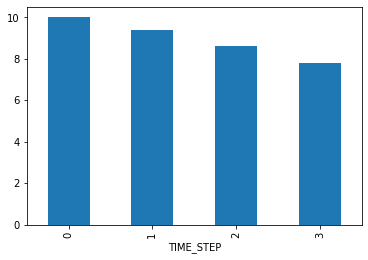

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
# Thickness at different time steps
data_TS.groupby("TIME_STEP")["WT"].mean().plot.bar()
plt.show()

In [0]:
data_TS["WT_Diff"] = data_TS.WT[0] - data_TS["WT"]
data_TS

,CML_ID,TIME_STEP,WT,ML,CR,prev_CR,WT_Diff
0,0,0,10,0,NaN,NaN,0
4,1,0,10,0,NaN,NaN,0
8,2,0,10,0,NaN,NaN,0
12,3,0,10,0,NaN,NaN,0
16,4,0,10,0,NaN,NaN,0
1,0,1,10,0,0.0,NaN,0
5,1,1,10,0,0.0,NaN,0
9,2,1,8,-2,2.0,NaN,2
13,3,1,10,0,0.0,NaN,0
17,4,1,9,-1,1.0,NaN,1


In [0]:
data_TS_1 = data_TS.drop(["CML_ID", "WT", "WT_Diff"], axis=1)
data_TS_1

,TIME_STEP,ML,CR,prev_CR
0,0,0,NaN,NaN
4,0,0,NaN,NaN
8,0,0,NaN,NaN
12,0,0,NaN,NaN
16,0,0,NaN,NaN
1,1,0,0.0,NaN
5,1,0,0.0,NaN
9,1,-2,2.0,NaN
13,1,0,0.0,NaN
17,1,-1,1.0,NaN


#Discussion
Use this section to discuss your solution. 

1.   What are the strengths and weaknesses of the predictions produced with your solution?
2.   If you had more time, what you have done differently? And more important, what would have been the advantages of the solution you would have implemented if you had more time.